In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ShortCorridorEnv:
    """
    Short Corridor Gridworld
    States: 0 (start), 1, 2, 3 (terminal)
    Actions: 0 (left), 1 (right) or 1 (left), 0 (right) for state 1
    Rewards: -1 per step
    """

    def __init__(self):
        self.n_states = 4
        self.start_state = 0
        self.terminal_state = 3
        self.step_penalty = -1

    def reset(self):
        """Reset environment to start state"""
        self.state = self.start_state
        return self.state

    def step(self, action):
        """
        Take an action in the environment.
        Args: action (int)
        Returns: next_state (int), reward (int), terminal (bool)
        """
        # Transition logic
        if self.state == 0:
            # state 0: left = stay, right = 1
            if action == 1:
                self.state = 1
        elif self.state == 1:
            # state 1: reversed actions
            if action == 0:
                self.state = 2
            elif action == 1:
                self.state = 0
        elif self.state == 2:
            # state 2: normal left and right
            if action == 0:
                self.state = 1
            elif action == 1:
                self.state = 3

        terminal = (self.state == self.terminal_state)
        reward = self.step_penalty
        return self.state, reward, terminal

    def action_feature(self, action):
        """
        Return action feature vector x(s, a)
        x(s,right) = [1, 0]^T
        x(s,left) =  [0, 1]^T
        """
        if action == 1:
            return np.array([1.0, 0.0])
        elif action == 0:
            return np.array([0.0, 1.0])

In [26]:
def softmax(x):
    """softmax policy"""
    ex = np.exp(x)
    return ex / np.sum(ex)


def get_policy(theta):
    """get π(a|θ)"""
    pre_probs = np.array([np.dot(theta, [0, 1]),  # left
                          np.dot(theta, [1, 0])])  # right
    return softmax(pre_probs)


def sample_action(probs):
    """get random action with probability distribution"""
    return np.random.choice([0, 1], p=probs)


def get_score_func(action, probs):
    """
    the score function under softmax policy:
    ∇ log π(a|θ) = x(s,a) - E_π x(s,·)
    """
    x_action = np.array([0, 1]) if action == 0 else np.array([1, 0])
    summ = probs[0] * np.array([0, 1]) + probs[1] * np.array([1, 0])
    return x_action - summ


def REINFORCE(env, alpha, episode=1000, gamma=1.0, init_theta=[0, 0]):
    """
    Main loop for implementing the REINFORCE algorithm (with softmax policy)
    Args: env, alpha (float), episode (int, default 1000), gamma (float, default 1.0), init_theta (array, default [0,0])
    Returns: theta (array, params after training), returns (array, return G_0 for each episode)
    """

    # initialize returns array
    returns = []
    # initialize theta with random guess before training
    theta = init_theta

    for ep in range(episode):
        # Generate an episode
        trajectory = []  # each element: (state, action, reward)
        state = env.reset()
        terminal = False

        # do the loop in the environment
        while not terminal:
            probs = get_policy(theta)
            action = sample_action(probs)
            next_state, reward, terminal = env.step(action)
            trajectory.append((state, action, reward))
            state = next_state

        # Compute returns G_t and update θ
        G = 0
        for t in reversed(range(len(trajectory))):
            state_t, action_t, reward_t = trajectory[t]
            G = reward_t + gamma * G  # accumulate return from future time setp
            probs = get_policy(theta)
            grad = get_score_func(action_t, probs)
            theta += alpha * grad * G

        # append the return for this episode
        returns.append(G)

        # report the progress
        if (ep + 1) % 100 == 0:
            avg_return = np.mean(returns[-100:])
            print(
                f"Running for α: {alpha}, Episode {ep + 1}, Avg Return (last 100 episode): {avg_return:.2f}, θ: {theta}")

    return theta, returns

In [23]:
# initialize environment
env = ShortCorridorEnv()

# set params
run = 100
episode = 1000
alphas = [2**-12, 2**-13, 2**-14]
gamma = 1.0
init_theta = [-1, 1]

# initialize array to store G0 values
G0_each_run = np.zeros((len(alphas), run, episode))

# run the experiment
for i, alpha in enumerate(alphas):
    for j in range(run):
        _, G0_each_run[i, j, :] = REINFORCE(env, alpha, episode, gamma, init_theta)

# calculate the average over 100 runs
avg_G0 = np.mean(G0_each_run, axis=1)

Running for α: 0.000244140625, Episode 100, Avg Return (last 100): -29.23, θ: [-0.7354515  0.7354515]
Running for α: 0.000244140625, Episode 200, Avg Return (last 100): -19.43, θ: [-0.52252311  0.52252311]
Running for α: 0.000244140625, Episode 300, Avg Return (last 100): -14.01, θ: [-0.26264784  0.26264784]
Running for α: 0.000244140625, Episode 400, Avg Return (last 100): -14.87, θ: [-0.2029622  0.2029622]
Running for α: 0.000244140625, Episode 500, Avg Return (last 100): -12.34, θ: [-0.16313215  0.16313215]
Running for α: 0.000244140625, Episode 600, Avg Return (last 100): -10.95, θ: [-0.14952236  0.14952236]
Running for α: 0.000244140625, Episode 700, Avg Return (last 100): -12.03, θ: [-0.01437991  0.01437991]
Running for α: 0.000244140625, Episode 800, Avg Return (last 100): -12.91, θ: [ 0.17908988 -0.17908988]
Running for α: 0.000244140625, Episode 900, Avg Return (last 100): -11.42, θ: [ 0.17799291 -0.17799291]
Running for α: 0.000244140625, Episode 1000, Avg Return (last 100): 

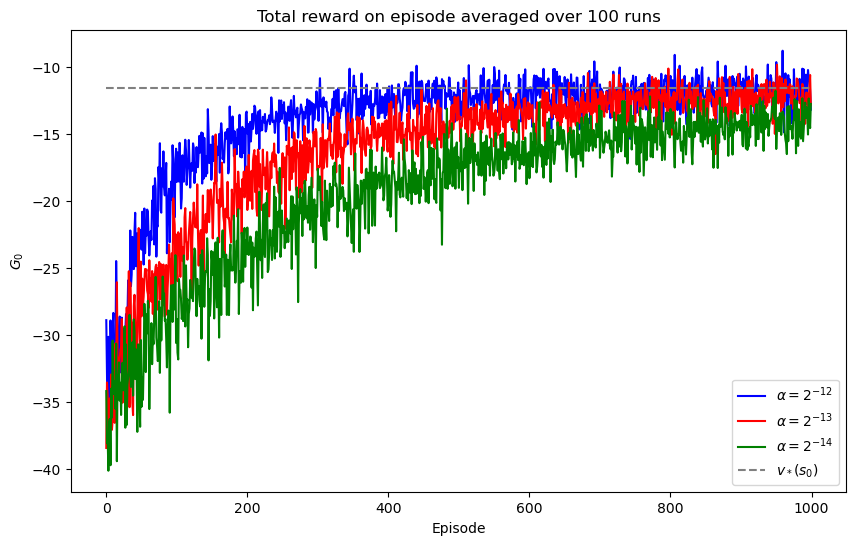

In [27]:
# plot results
x = np.arange(episode)
colors = ['blue', 'red', 'green']
plt.figure(figsize=(10, 6))

for i, alpha in enumerate(alphas):
    plt.plot(x, avg_G0[i, :], label=r'$\alpha=2^{{{:.0f}}}$'.format(
        np.log2(alpha)), color=colors[i])

# true optimum in example 13.1 is -11.6
true_v0 = -11.6
y = [true_v0] * len(x)
plt.plot(x, y, linestyle='dashed', color='gray', label=r'$v_*(s_0)$')

plt.title(f"Total reward on episode averaged over {run} runs")
plt.xlabel('Episode')
plt.ylabel(r'$G_{0}$')

plt.legend(loc='lower right')
plt.show()

The original figure, which is somehow slightly different:


![](img/13.1.png)